In [2]:
conda install -c conda-forge imbalanced-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install -c conda-forge pdpbox

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [4]:
conda install -c conda-forge ipywidgets

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [427]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, plot_roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier 
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import ipywidgets
import shap
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [428]:
df = pd.read_csv('/Users/jasongersing/Desktop/DS Projects/WA_Fn-UseC_-HR-Employee-Attrition 2.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [429]:
def wrangle(df):
    
    # Dropping columns with high number of NaN values
    df.dropna(axis=1, thresh=500, inplace = True)
        
    # Dropping columns with unique values
    df.drop(columns=['EmployeeNumber'], inplace=True)
    
    # Dropping columns with constant values
    df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], inplace=True)

    # Clean binary encoded columns
    df['Attrition'] = (df['Attrition'] == 'Yes').astype(int)
    df['Gender'] = (df['Gender'] == 'Male').astype(int)
    df['MaritalStatus'] = (df['MaritalStatus'] == 'Married').astype(int)
    df['OverTime'] = (df['OverTime'] == 'Yes').astype(int)
    
    # Brute force OneHotEncoder
    dept = ['Research & Development', 'Sales', 'Human Resources']
    for dept in df['Department']:
      df[dept] = (df['Department'].str.contains(dept, regex=True)).astype(int)

    field = ['Life Sciences', 'Medical', 'Marketing', 'Technical Degree', 'Other', 'Human Resources']
    for field in df['EducationField']:
      df[field] = (df['EducationField'].str.contains(dept, regex=True)).astype(int)

    role = ['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufactoring Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources']
    for role in df['JobRole']:
      df[role] = (df['JobRole'].str.contains(dept, regex=True)).astype(int)

    # Brute force OrdinalEncoder
    df['BusinessTravel'] = pd.factorize(df['BusinessTravel'])[0]

    df = df.drop(columns=['Department', 'EducationField', 'JobRole'])
    
    
    return df

df = wrangle(df)

In [430]:
# Confirm wrangle function worked.
df.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,Marketing,Technical Degree,Sales Executive,Research Scientist,Laboratory Technician,Manufacturing Director,Healthcare Representative,Manager,Sales Representative,Research Director
0,41,1,0,1102,1,2,2,0,94,3,...,0,0,0,0,0,0,0,0,0,0
1,49,0,1,279,8,1,3,1,61,2,...,0,0,0,0,0,0,0,0,0,0
2,37,1,0,1373,2,2,4,1,92,2,...,0,0,0,0,0,0,0,0,0,0
3,33,0,1,1392,3,4,4,0,56,3,...,0,0,0,0,0,0,0,0,0,0
4,27,0,0,591,2,1,1,1,40,3,...,0,0,0,0,0,0,0,0,0,0


In [431]:
target = 'Attrition'
y = df[target]
X = df.drop(columns=target)

In [432]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.4, random_state=42)

In [433]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=42)

In [434]:
# Sanity check
len(X_train) + len(X_val) + len(X_test) == len(X)

True

In [435]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((1470, 43), (882, 43), (294, 43), (294, 43))

In [436]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.8231292517006803


In [437]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [438]:
# Model 2: Random Forest
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf.fit(X_train, y_train);

In [439]:
# Model 3: XGBoost (Not using a pipeline in order to use Shap later)

model_xgb = XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1, learning_rate=.2) 
model_xgb.fit(X_train, y_train)

[14:23:47] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=75, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [440]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8741496598639455
Validation Accuracy (LOGR): 0.8809523809523809


In [441]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8809523809523809


In [442]:
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_val, y_val))

Training Accuracy (XGB): 1.0
Validation Accuracy (XGB): 0.8843537414965986


Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       256
           1       0.57      0.32      0.41        38

    accuracy                           0.88       294
   macro avg       0.74      0.64      0.67       294
weighted avg       0.86      0.88      0.87       294



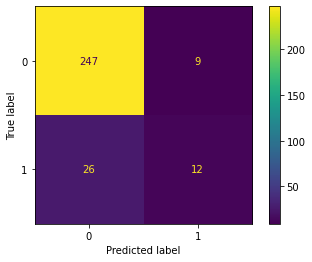

In [443]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val);

Random Forest
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       256
           1       0.71      0.13      0.22        38

    accuracy                           0.88       294
   macro avg       0.80      0.56      0.58       294
weighted avg       0.86      0.88      0.84       294



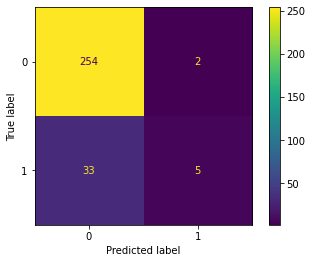

In [444]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val);

XG Boost
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       256
           1       0.64      0.24      0.35        38

    accuracy                           0.88       294
   macro avg       0.77      0.61      0.64       294
weighted avg       0.86      0.88      0.86       294



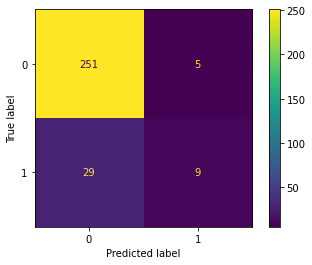

In [445]:
print('XG Boost')
print(classification_report(y_val, model_xgb.predict(X_val)))
plot_confusion_matrix(model_xgb, X_val, y_val);

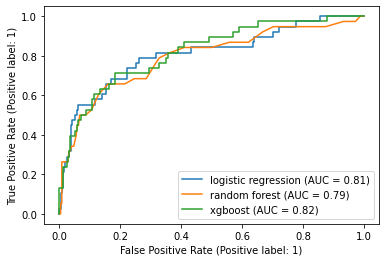

In [446]:
#Plot ROC curves for the three models

lr = plot_roc_curve(model_lr,
               X_val,
               y_val,
               name='logistic regression');

rf = plot_roc_curve(model_rf,
               X_val,
               y_val,
               ax=lr.ax_,
               name='random forest');

xgb = plot_roc_curve(model_xgb,
               X_val,
               y_val,
               ax=lr.ax_,
               name='xgboost');

In [447]:
roc_auc_score(y_val, model_lr.predict_proba(X_val)[:,-1])

0.8071546052631577

In [448]:
roc_auc_score(y_val, model_rf.predict_proba(X_val)[:,-1])

0.7941509046052632

In [449]:
roc_auc_score(y_val, model_xgb.predict_proba(X_val)[:,-1])

0.8193873355263157

In [450]:
# Get predicted probabilities from model

y_pred_prob = model_xgb.predict_proba(X_val)[:,-1]

# Input true labels and probability predictions 
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# Put data into dictionary
data = {'false_pos_rate': fpr,
        'true_pos_rate': tpr,
        'thresholds':thresholds}

df_pos = pd.DataFrame(data)
df_pos

,false_pos_rate,true_pos_rate,thresholds
0,0.000000,0.000000,1.948723
1,0.000000,0.026316,0.948723
2,0.000000,0.131579,0.837836
3,0.011719,0.131579,0.763679
4,0.011719,0.236842,0.659992
5,0.023438,0.236842,0.485952
6,0.023438,0.263158,0.470688
7,0.027344,0.263158,0.445672
8,0.027344,0.289474,0.440857
9,0.031250,0.289474,0.429563


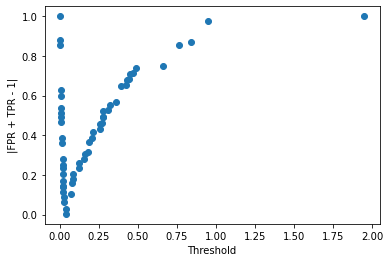

In [533]:
# Create a plot that takes the p value where TPR(p) == TNR(p). Since TPR = 1 - FPR, we get FPR + TPR -1 for our 
# y-axis. We plot this against different thresholds and determine the minimum value. 

plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [452]:
# To determine the exact minimum

thresholds[np.argmin(np.abs(fpr+tpr-1))]

0.036081888

In [453]:
# Use new threshold and check validation accuracy.

y_pred_new_threshold = (model_xgb.predict_proba(X_val)[:,1]>=0.036).astype(int)

In [454]:
print('Validation Accuracy (XGB):', accuracy_score(y_val, y_pred_new_threshold))

Validation Accuracy (XGB): 0.7074829931972789


In [455]:
# Try a different method (Maximize Accuracy), which better accounts for unblanced datasets.

threshold = []
accuracy = []

for p in np.unique(model_xgb.predict_proba(X_val)[:,1]):
  threshold.append(p)
  y_pred = (model_xgb.predict_proba(X_val)[:,1] >= p).astype(int)
  accuracy.append(balanced_accuracy_score(y_val,y_pred))

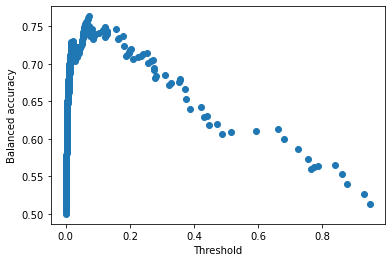

In [456]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [457]:
# Determine exact maximum

threshold[np.argmax(accuracy)]

0.0725931

In [458]:
# Use new threshold and check validation accuracy.

y_pred_new_threshold_2 = (model_xgb.predict_proba(X_val)[:,1]>=0.073).astype(int)

In [459]:
print('Validation Accuracy (XGB):', accuracy_score(y_val, y_pred_new_threshold_2))

Validation Accuracy (XGB): 0.7993197278911565


In [460]:
# Neither new threshold improves our validation accuracy score. 

In [461]:
# To confirm above method, create a new column in our dataframe that employs the distance formula |
# in order to find the minimum distance between the ROC curve and the top left corner (0,1). 

df_pos['distance'] = np.sqrt((1 - df_pos['true_pos_rate'])**2 + (0 - df_pos['false_pos_rate'])**2)
df_pos

,false_pos_rate,true_pos_rate,thresholds,distance
0,0.000000,0.000000,1.948723,1.000000
1,0.000000,0.026316,0.948723,0.973684
2,0.000000,0.131579,0.837836,0.868421
3,0.011719,0.131579,0.763679,0.868500
4,0.011719,0.236842,0.659992,0.763248
5,0.023438,0.236842,0.485952,0.763518
6,0.023438,0.263158,0.470688,0.737215
7,0.027344,0.263158,0.445672,0.737349
8,0.027344,0.289474,0.440857,0.711052
9,0.031250,0.289474,0.429563,0.711213


In [462]:
# The minimum distance (0.342785) is at the same threshold value given using the Maximizing Accuracy method. 

In [463]:
# Use trial and error to find a threshold that improves our validation accuracy score. 

y_pred_new_threshold_3 = (model_xgb.predict_proba(X_val)[:,1]>=0.82).astype(int)

In [464]:
print('Validation Accuracy (XGB):', accuracy_score(y_val, y_pred_new_threshold_3))

Validation Accuracy (XGB): 0.8877551020408163


In [465]:
# A very slight improvement in our validation accuracy score. 

Text(0, 0.5, 'Feature')

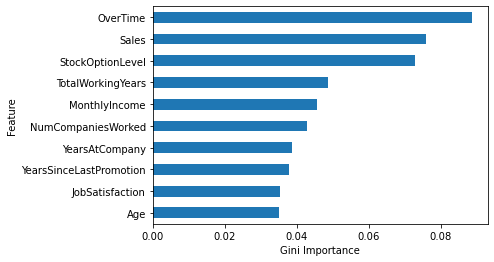

In [466]:
# Plot the gini importances of our features on the target.

importances = model_xgb.feature_importances_
feature_names =X_train.columns
feat_imp= pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [467]:
#Train a model (XGBoost) for permutation_importance 

model_perm = XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1, learning_rate=.2) 


model_perm.fit(X_train, y_train)

[14:23:50] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=75, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [468]:
model_perm.score(X_val, y_val)

0.8843537414965986

In [469]:
# Use Permutation_Importance as another way to determine impact of our features
perm_imp = permutation_importance(model_perm, X_val, y_val,random_state=42)
perm_imp

{'importances_mean': array([ 0.00272109,  0.00612245, -0.00136054, -0.00680272, -0.00204082,
         0.00612245, -0.00136054, -0.00408163,  0.00204082, -0.00204082,
        -0.00272109,  0.        ,  0.0047619 ,  0.00408163,  0.00952381,
         0.02857143, -0.00272109,  0.        , -0.00612245,  0.        ,
         0.00340136,  0.00340136,  0.00272109, -0.00272109, -0.00068027,
         0.00204082,  0.00136054, -0.00340136,  0.00340136,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]),
 'importances_std': array([0.00726332, 0.00396663, 0.00630858, 0.00481025, 0.00593047,
        0.00544218, 0.00272109, 0.00136054, 0.00272109, 0.00166632,
        0.00544218, 0.00215121, 0.00552656, 0.00254535, 0.00897341,
        0.00346872, 0.00544218, 0.        , 0.00757519, 0.01031684,
        0.00481025, 0.00215121, 0.00254535, 0.00136054, 

In [470]:
# Organize data into DateFrame to better interpret

data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}


df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

In [471]:
df_perm

,imp_mean,imp_std
DistanceFromHome,-0.006803,0.004810
RelationshipSatisfaction,-0.006122,0.007575
HourlyRate,-0.004082,0.001361
Sales,-0.003401,0.002151
PercentSalaryHike,-0.002721,0.005442
YearsAtCompany,-0.002721,0.001361
JobSatisfaction,-0.002721,0.005442
JobLevel,-0.002041,0.001666
Education,-0.002041,0.005930
DailyRate,-0.001361,0.006309


In [534]:
# Choose a feature to 
col = 'TotalWorkingYears'
X_val_perm = X_val.copy()
X_val_perm[col] = np.random.permutation(X_val_perm[col])

In [473]:
model_perm.score(X_val_perm, y_val)

0.891156462585034

In [474]:
feature = 'TotalWorkingYears'

In [475]:
isolate= pdp_isolate(
    model_xgb,
    dataset= X_val, 
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_ax': <AxesSubplot:xlabel='TotalWorkingYears'>})

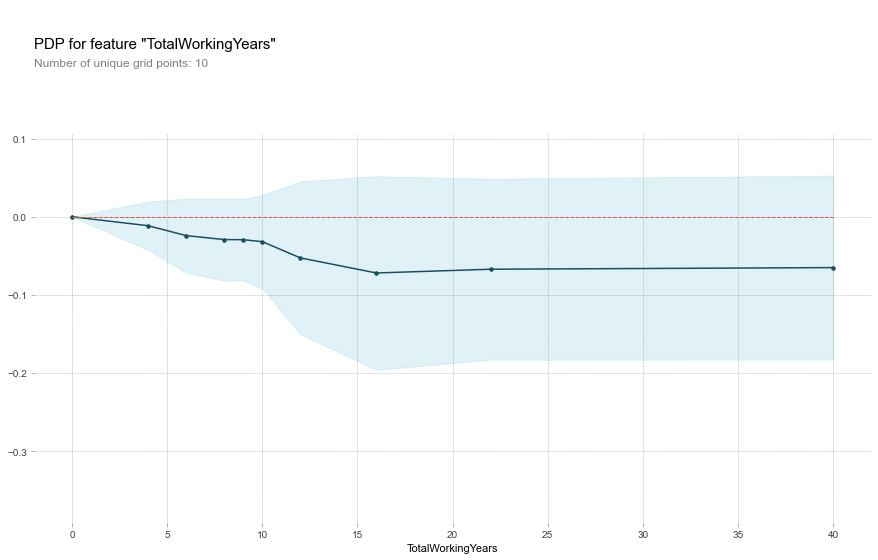

In [476]:
pdp_plot(isolate, feature_name=feature)

In [477]:
feature = 'Age'

In [478]:
isolate= pdp_isolate(
    model_xgb,
    dataset= X_val, 
    model_features=X_val.columns,
    feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='Age'>})

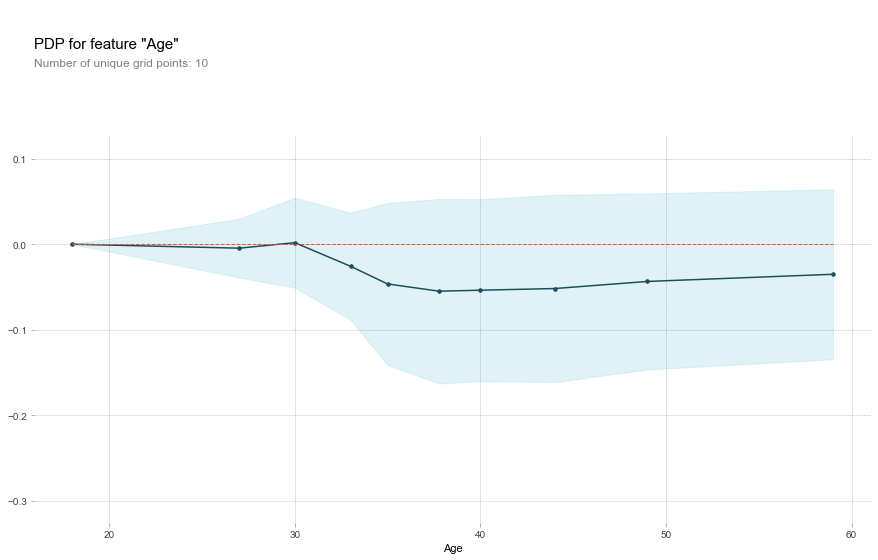

In [479]:
pdp_plot(isolate, feature_name=feature)

In [480]:
features = ['Age','TotalWorkingYears']

In [481]:
interact= pdp_interact(
    model_xgb,
    dataset= X_val, 
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': <AxesSubplot:xlabel='Age', ylabel='TotalWorkingYears'>})

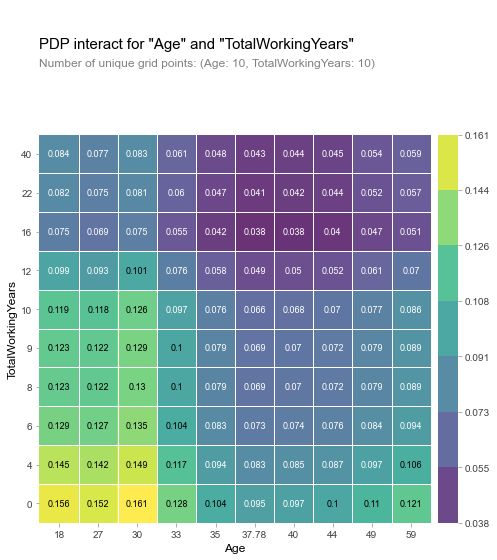

In [482]:
pdp_interact_plot(interact,plot_type='grid', feature_names=features)

In [483]:
sample_row = X_val.tail(1)

In [484]:
sample_row

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,Marketing,Technical Degree,Sales Executive,Research Scientist,Laboratory Technician,Manufacturing Director,Healthcare Representative,Manager,Sales Representative,Research Director
607,49,0,1184,11,3,3,0,43,3,3,...,0,0,0,0,0,0,0,0,0,0


In [485]:
explainer = shap.TreeExplainer(model_xgb)

In [486]:
shap_values = explainer.shap_values(sample_row)

shap.initjs() 
shap.force_plot(
    base_value= explainer.expected_value,
    shap_values=shap_values,
    features=sample_row)

In [487]:
shap_values.shape

(1, 43)

In [488]:
shap_df = pd.DataFrame(data=shap_values[0], index=X_val.columns, columns=['shap_values'])

In [489]:
shap_df['shap_values'].sum() + -1.885

-4.839756736755371

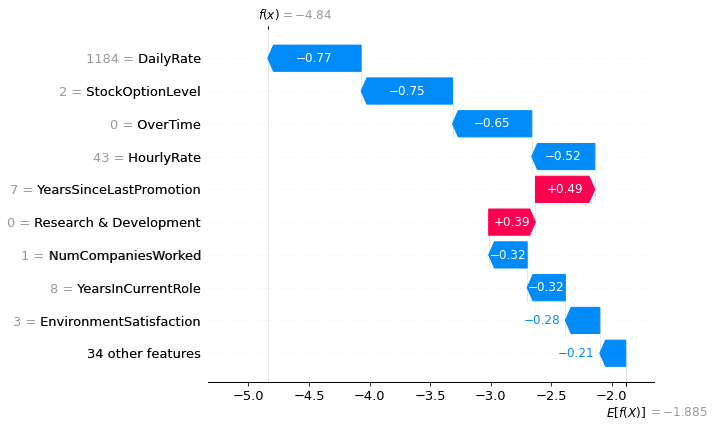

In [490]:
# waterfall plot 

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(sample_row)
shap.plots.waterfall(shap_values[0])

In [491]:
df_new = df[['Attrition','DailyRate', 'StockOptionLevel', 'OverTime', 'HourlyRate', 'YearsSinceLastPromotion', 'Research & Development', 'NumCompaniesWorked', 'YearsInCurrentRole', 'EnvironmentSatisfaction']]

In [492]:
df_new.head()

,Attrition,DailyRate,StockOptionLevel,OverTime,HourlyRate,YearsSinceLastPromotion,Research & Development,NumCompaniesWorked,YearsInCurrentRole,EnvironmentSatisfaction
0,1,1102,0,1,94,0,0,8,4,2
1,0,279,1,0,61,1,1,1,7,3
2,1,1373,0,1,92,0,1,6,0,4
3,0,1392,0,1,56,3,1,1,7,4
4,0,591,1,0,40,2,1,9,2,1


In [493]:
target = 'Attrition'
y = df_new[target]
X = df_new.drop(columns=target)

In [494]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.4, random_state=42)

In [495]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=42)

In [496]:
# Sanity check
len(X_train) + len(X_val) + len(X_test) == len(X)

True

In [497]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((1470, 9), (882, 9), (294, 9), (294, 9))

In [498]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.8231292517006803


In [499]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [500]:
# Model 2: Random Forest
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf.fit(X_train, y_train);

In [501]:
# Model 3: XGBoost

model_xgb = XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1, learning_rate=.2) 
model_xgb.fit(X_train, y_train)

[14:23:55] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:23:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=75, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [502]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8299319727891157
Validation Accuracy (LOGR): 0.8741496598639455


In [503]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8741496598639455


In [504]:
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_val, y_val))

Training Accuracy (XGB): 1.0
Validation Accuracy (XGB): 0.8503401360544217


Logistic Regression
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       256
           1       0.56      0.13      0.21        38

    accuracy                           0.87       294
   macro avg       0.72      0.56      0.57       294
weighted avg       0.84      0.87      0.84       294



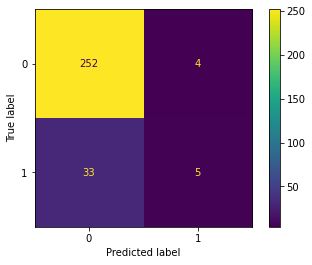

In [505]:
print('Logistic Regression')
print(classification_report(y_val, model_lr.predict(X_val)))
plot_confusion_matrix(model_lr, X_val, y_val);

Random Forest
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       256
           1       0.53      0.21      0.30        38

    accuracy                           0.87       294
   macro avg       0.71      0.59      0.62       294
weighted avg       0.85      0.87      0.85       294



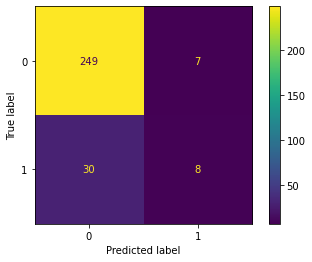

In [506]:
print('Random Forest')
print(classification_report(y_val, model_rf.predict(X_val)))
plot_confusion_matrix(model_rf, X_val, y_val);

XG Boost
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       256
           1       0.33      0.16      0.21        38

    accuracy                           0.85       294
   macro avg       0.61      0.56      0.57       294
weighted avg       0.81      0.85      0.83       294



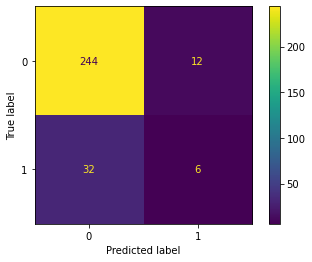

In [507]:
print('XG Boost')
print(classification_report(y_val, model_xgb.predict(X_val)))
plot_confusion_matrix(model_xgb, X_val, y_val);

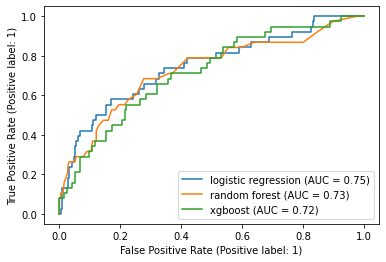

In [508]:
lr = plot_roc_curve(model_lr,
               X_val,
               y_val,
               name='logistic regression');

rf = plot_roc_curve(model_rf,
               X_val,
               y_val,
               ax=lr.ax_,
               name='random forest');

xgb = plot_roc_curve(model_xgb,
               X_val,
               y_val,
               ax=lr.ax_,
               name='xgboost');

In [509]:
df_perm.tail(8)

,imp_mean,imp_std
Research & Development,0.003401,0.002151
TrainingTimesLastYear,0.003401,0.002151
MonthlyRate,0.004082,0.002545
MonthlyIncome,0.004762,0.005527
EnvironmentSatisfaction,0.006122,0.005442
BusinessTravel,0.006122,0.003967
NumCompaniesWorked,0.009524,0.008973
OverTime,0.028571,0.003469


In [510]:
df_newer = df[['Attrition','TrainingTimesLastYear', 'MonthlyRate', 'MonthlyIncome', 'BusinessTravel', 'OverTime', 'YearsSinceLastPromotion', 'Research & Development', 'NumCompaniesWorked',  'EnvironmentSatisfaction']]
df_newer.head()

,Attrition,TrainingTimesLastYear,MonthlyRate,MonthlyIncome,BusinessTravel,OverTime,YearsSinceLastPromotion,Research & Development,NumCompaniesWorked,EnvironmentSatisfaction
0,1,0,19479,5993,0,1,0,0,8,2
1,0,3,24907,5130,1,0,1,1,1,3
2,1,3,2396,2090,0,1,0,1,6,4
3,0,3,23159,2909,1,1,3,1,1,4
4,0,3,16632,3468,0,0,2,1,9,1


In [511]:
target = 'Attrition'
y = df_newer[target]
X = df_newer.drop(columns=target)

In [512]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.4, random_state=42)

In [513]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=42)

In [514]:
# Sanity check
len(X_train) + len(X_val) + len(X_test) == len(X)

True

In [515]:
X.shape, X_train.shape, X_val.shape, X_test.shape

((1470, 9), (882, 9), (294, 9), (294, 9))

In [516]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.8231292517006803


In [517]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [518]:
# Model 2: Random Forest
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf.fit(X_train, y_train);

In [519]:
# Model 3: XGBoost

model_xgb = XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1, learning_rate=.2) 
model_xgb.fit(X_train, y_train)

[14:24:13] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:24:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=75, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [520]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_val, y_val))

Training Accuracy (LOGR): 0.8344671201814059
Validation Accuracy (LOGR): 0.8741496598639455


In [521]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8639455782312925


In [522]:
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_val, y_val))

Training Accuracy (XGB): 0.9988662131519275
Validation Accuracy (XGB): 0.8605442176870748


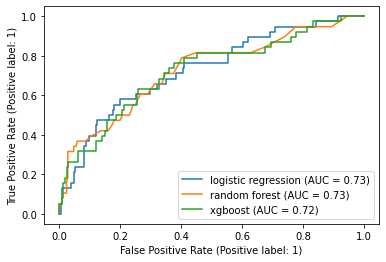

In [523]:
lr = plot_roc_curve(model_lr,
               X_val,
               y_val,
               name='logistic regression');

rf = plot_roc_curve(model_rf,
               X_val,
               y_val,
               ax=lr.ax_,
               name='random forest');

xgb = plot_roc_curve(model_xgb,
               X_val,
               y_val,
               ax=lr.ax_,
               name='xgboost');

In [524]:
# Removing features - based either on Perumutation_Importance or on Shapley Plot - has not increased our AUC values |
# or our validation scores. They appear not to be creating noise; on the contrary, they are helping the model.

In [525]:
target = 'Attrition'
y = df[target]
X = df.drop(columns=target)

In [526]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.4, random_state=42)

In [527]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=42)

In [528]:
# Sanity check
len(X_train) + len(X_val) + len(X_test) == len(X)

True

In [529]:
# All columns from wrangled DF are back
X.shape, X_train.shape, X_val.shape, X_test.shape

((1470, 43), (882, 43), (294, 43), (294, 43))

In [530]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.8231292517006803


In [422]:
# Model 1: Logistic Regression
model_lr = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression()
)

model_lr.fit(X_train, y_train);

In [423]:
print('Training Accuracy (LOGR):', model_lr.score(X_train, y_train))
print('Validation Accuracy (LOGR):', model_lr.score(X_test, y_test))

Training Accuracy (LOGR): 0.8741496598639455
Validation Accuracy (LOGR): 0.8877551020408163


In [424]:
# Model 2: Random Forest
model_rf = RandomForestClassifier(n_jobs=-1, random_state=42)

model_rf.fit(X_train, y_train);

In [425]:
print('Training Accuracy (RF):', model_rf.score(X_train, y_train))
print('Validation Accuracy (RF):', model_rf.score(X_val, y_val))

Training Accuracy (RF): 1.0
Validation Accuracy (RF): 0.8809523809523809


In [531]:
# Model 3: XGBoost

model_xgb = XGBClassifier(random_state=42,n_estimator=75, n_jobs=-1, learning_rate=.2) 
model_xgb.fit(X_train, y_train)

[14:25:24] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:25:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimator=75, n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [532]:
print('Training Accuracy (XGB):', model_xgb.score(X_train, y_train))
print('Validation Accuracy (XGB):', model_xgb.score(X_test, y_test))

Training Accuracy (XGB): 1.0
Validation Accuracy (XGB): 0.8571428571428571


In [ ]:
# The logistic regression model performed best on the test data. |
# The random forest model and the XGBoost model were overfitting. 